# Milestone 3: Machine Learning Model Development and Optimization

##  Import libraries

In [1]:
import pandas as pd
from rich.jupyter import display
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,ConfusionMatrixDisplay,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
import joblib
import json
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
X_train = pd.read_csv("../data/processed/X_train_scaled.csv")
X_test  = pd.read_csv("../data/processed/X_test_scaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

## Apply ADASYN Oversampling

In [3]:
from imblearn.over_sampling import ADASYN
ad = ADASYN(random_state=42)
X_train_res, y_train_res = ad.fit_resample(X_train, y_train)

## Define models and their hyperparameters

In [4]:
models_params = {
    "SVC": (SVC(),{"C": [0.1, 1, 10],"kernel": ["linear", "rbf"],"gamma": [0.01, 0.1, 1]},),
    "Decision Tree": (DecisionTreeClassifier(),{"criterion": ["gini", "entropy"],"max_depth": [None, 5, 10, 20],"min_samples_split": [2, 5, 10],},),
    "Random Forest": (RandomForestClassifier(),{"n_estimators": [100, 200, 300],"max_depth": [None, 10, 20, 30],"min_samples_split": [2, 5, 10],"bootstrap": [True, False]},),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric="logloss"),{"n_estimators": [100, 200],"max_depth": [3, 5, 7],"learning_rate": [0.01, 0.1, 0.2],"subsample": [0.7, 1.0]},),
    "Logistic Regression": (LogisticRegression(max_iter=1000),{"C": [0.01, 0.1, 1, 10],"penalty": ["l1", "l2"],"solver": ["lbfgs","liblinear", "saga"]},),
    "KNN": (KNeighborsClassifier(),{"n_neighbors": range(1,11),"weights": ["uniform", "distance"],"metric": ["euclidean", "manhattan"]},),
    "GaussianNB": (GaussianNB(),{"var_smoothing": [1e-9, 1e-8, 1e-7]},)
}

## Perform GridSearchCV to find the best parameters for each model

In [5]:
best_parameter = {}
for name, (model, params) in models_params.items():
    print(f"\n Running GridSearch for: {name} ...")
    grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_res, y_train_res)
    best_parameter[name] = grid.best_estimator_


 Running GridSearch for: SVC ...

 Running GridSearch for: Decision Tree ...

 Running GridSearch for: Random Forest ...

 Running GridSearch for: XGBoost ...

 Running GridSearch for: Logistic Regression ...

 Running GridSearch for: KNN ...

 Running GridSearch for: GaussianNB ...


## Evaluate best models, save results, and generate performance summary

In [6]:
results = {}
summary = []
for name, model in best_parameter.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {"accuracy": acc, "auc": auc, "report": report}
    f1 = f1_score(y_test, y_pred, average="weighted")
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    joblib.dump(model, f"../models/{name}.joblib")
    summary.append({"name": name, "acc": acc, "auc": auc, "f1": f1, "prec": prec, "rec": rec})
    print(f"{name} -- Train Accuracy: {model.score(X_train_res,y_train_res):.2f} -- Test Accuracy: {model.score(X_test, y_test):.2f}")


SVC -- Train Accuracy: 1.00 -- Test Accuracy: 0.88
Decision Tree -- Train Accuracy: 1.00 -- Test Accuracy: 0.92
Random Forest -- Train Accuracy: 1.00 -- Test Accuracy: 0.96
XGBoost -- Train Accuracy: 1.00 -- Test Accuracy: 0.97
Logistic Regression -- Train Accuracy: 0.83 -- Test Accuracy: 0.84
KNN -- Train Accuracy: 1.00 -- Test Accuracy: 0.85
GaussianNB -- Train Accuracy: 0.82 -- Test Accuracy: 0.84


## Save detailed model results to JSON file

In [7]:
with open(r"../results/model_results.json", "w") as f:
    json.dump(results, f, indent=2)

## Plot and save ROC curves for all best models

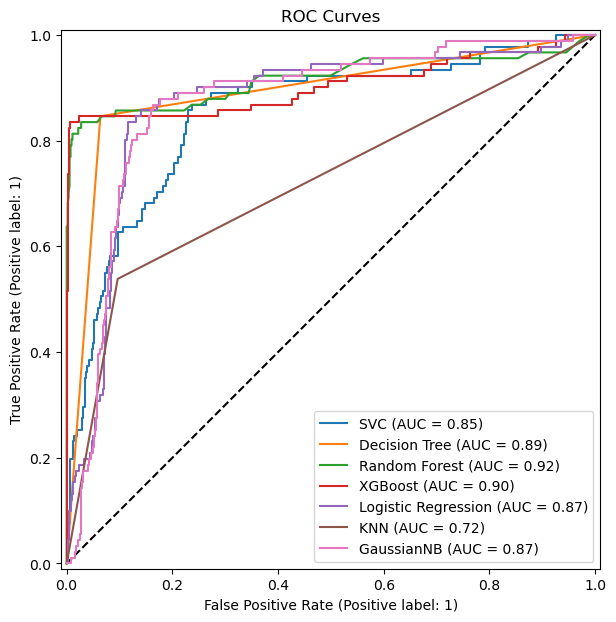

In [8]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(12,7))
plt.title("ROC Curves")
plt.plot([0,1],[0,1],"k--")
for name, model in best_parameter.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
plt.savefig(r"../results/roc_all_models.png")

## Plot and save confusion matrices for all best models

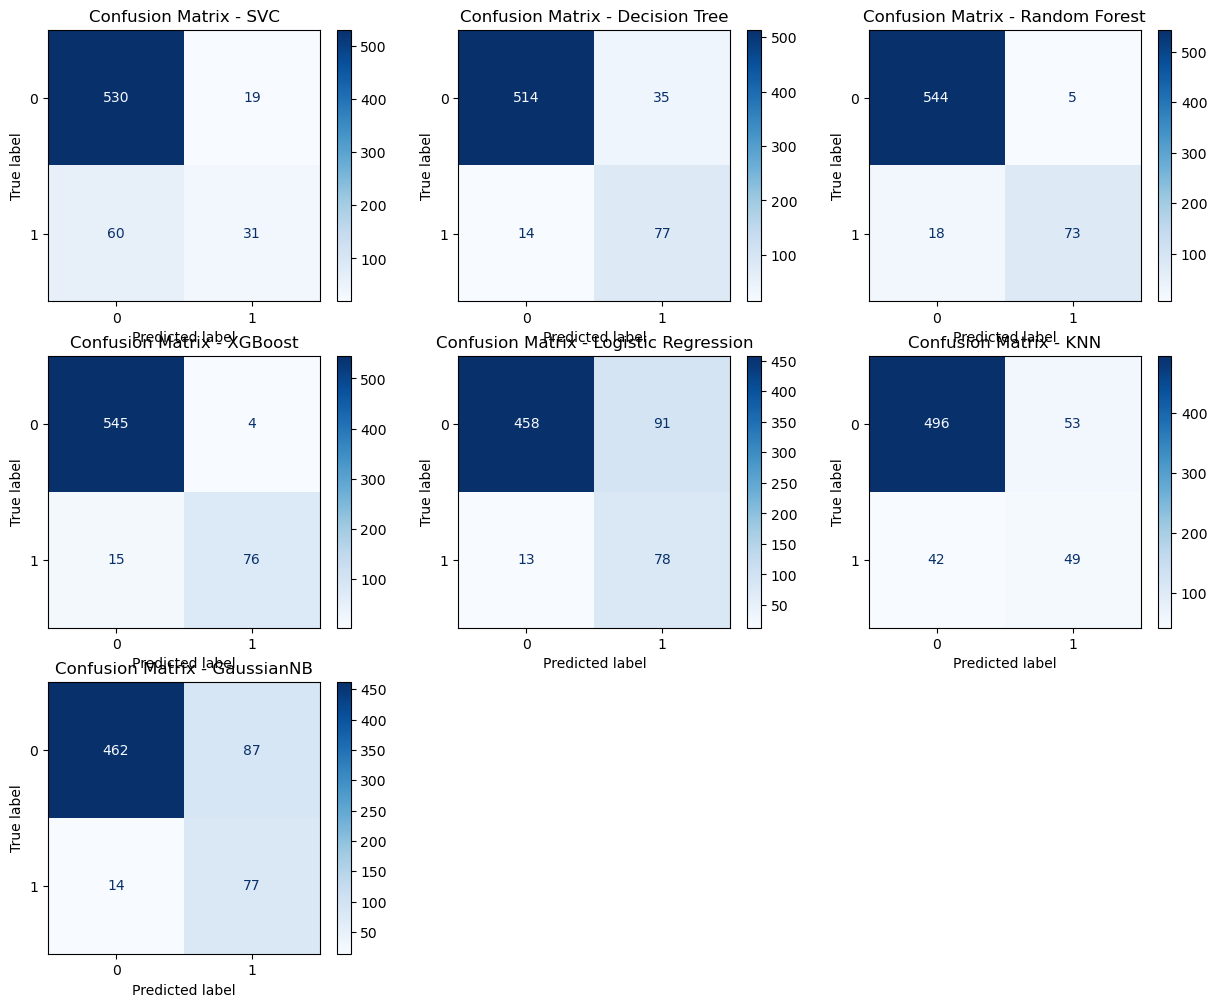

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for ax, (name, model) in zip(axes, best_parameter.items()):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax,cmap="Blues")
    ax.set_title(f"Confusion Matrix - {name}")
fig.delaxes(axes[7])
fig.delaxes(axes[8])
fig.savefig(r"../results/confusion_matrixs.png")

## Create and save summary of all model performances

In [14]:
summary = pd.DataFrame(summary)
summary = summary.sort_values(by="acc", ascending=False).reset_index(drop=True)
summary.to_csv("../results/models_summary.csv", index=False)

In [15]:
print(summary)

                  name       acc       auc        f1      prec       rec
0              XGBoost  0.970313  0.904462  0.969505  0.969914  0.970313
1        Random Forest  0.964063  0.917833  0.962891  0.963411  0.964063
2        Decision Tree  0.923438  0.891201  0.926651  0.932821  0.923438
3                  SVC  0.876563  0.852039  0.860838  0.858734  0.876563
4                  KNN  0.851562  0.720961  0.855042  0.859151  0.851562
5           GaussianNB  0.842187  0.871835  0.859157  0.899341  0.842187
6  Logistic Regression  0.837500  0.871274  0.855662  0.899761  0.837500


## Save the best-performing model

In [16]:
best_model_name = summary.loc[0, "name"]
best_model = best_parameter[best_model_name]
joblib.dump(best_model, f"../models/best.joblib")

['../models/best.joblib']